# Odometria wizyjna - Visual Odometry

Odometrię wizualną (VO) definiuje się jako proces szacowania ruchu robota (translacji i rotacji względem ramki odniesienia) poprzez obserwację sekwencji obrazów jego otoczenia. VO jest szczególnym przypadkiem techniki znanej jako Structure From Motion (SFM), która zajmuje się problemem trójwymiarowej rekonstrukcji zarówno struktury otoczenia, jak i pozycji kamery z sekwencyjnie uporządkowanych lub nieuporządkowanych zestawów obrazów. Ostatni etap SFM, polegający na ostatecznym dopracowaniu i globalnej optymalizacji zarówno póz kamery, jak i struktury, jest kosztowny obliczeniowo i zwykle wykonywany w trybie off-line. Natomiast estymacja pozycji kamery w VO musi być przeprowadzana w czasie rzeczywistym. W ostatnich latach zaproponowano wiele metod VO, które można podzielić na metody z wykorzystaniem kamer monokularnych i stereokamerowych. Metody te są następnie dzielone na dopasowywanie cech (dopasowywanie cech na wielu klatkach), śledzenie cech (dopasowywanie cech w sąsiednich klatkach) oraz techniki przepływu optycznego (oparte na intensywności wszystkich pikseli lub określonych regionów w sekwencyjnych obrazach).

Jednoczesna lokalizacja i mapowanie (SLAM) jest rozszerzeniem metody VO, która radzi sobie z dryfem, ale także SLAM jest procesem, w którym robot ma za zadanie zlokalizować się w nieznanym środowisku i jednocześnie zbudować jego mapę bez żadnych wcześniejszych informacji za pomocą zewnętrznych czujników (lub pojedynczego czujnika).


Odometra wizyjna składa się z kilku kroków:
1. Detekcja punktów charakterystycznych (zwykle ORB - FAST+BRIEF)
2. Dopasowanie punktów charakterystycznych (Brute-force lub FLANN)
3. Generowanie chmury punktów 3D - triangulacja
4. Eliminacja błędnej reprojekcji, filtracja RANSAC
5. Estymacja ruchu - wyznaczenie rotacji oraz translacji

Porównanie działania VO i SLAM:

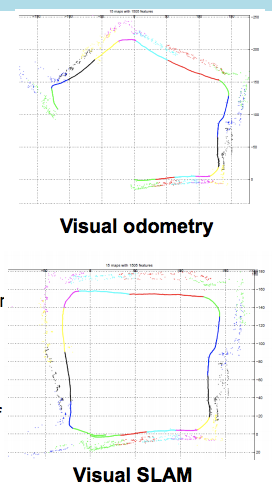

## Ćwiczenie

Celem ćwiczenia jest realizacja prostej odometrii wizyjnej, czyli wyznaczenie trajektorii ruchu samochodu poruszającego się po ulicach na podstawie zbioru danych KITTI.

Najpierw zaimportujmy potrzebne biblioteki...




In [40]:
import numpy as np
import cv2
import imutils
import os
from os.path import join

🔔 **TODO**: ustaw zmienną ``DATASET_DIR`` tak aby wskazywała na folder ze zbiorem danych KITTI


In [41]:
DATASET_DIR = 'data/KITTI/'

STAGE_FIRST_FRAME = 0
STAGE_SECOND_FRAME = 1
STAGE_DEFAULT_FRAME = 2
kMinNumFeature = 1500

## Definicja klasy PinholeCamera

Klasa ``PinholeCamera`` przechowuje rozmiar obrazu oraz parametry kamery, czyli ogniskową ``fx,fy``, punkt centralny ``cx, cy`` oraz parametry dystorsji: ``k1, k2, p1, p2, k3``.


In [42]:
class PinholeCamera:
    def __init__(self, width, height, fx, fy, cx, cy, 
                k1=0.0, k2=0.0, p1=0.0, p2=0.0, k3=0.0):
        self.width = width
        self.height = height
        self.fx = fx
        self.fy = fy
        self.cx = cx
        self.cy = cy
        self.distortion = (abs(k1) > 0.0000001)
        self.d = [k1, k2, p1, p2, k3]

## Funkcja pomocnicza

*   ``featureTracking`` - wyznaczenie przepływu optycznego oraz pozostawienie jedynie punktów charakterystycznych dla których możliwe było uzyskanie OF.

🔔 **TODO (1)** W funkcji do śledzenia punktów ``featureTracking`` wyznacz przepływ optyczny i punkty charakakterystyczne:

* Wykorzystaj funkcję ``cv2.calcOpticalFlowPyrLK()`` do wyznaczenia przepływu optycznego. 
* Jeden z parametrów funkcji ``status`` oznacza poprawność wyznaczenia przepływu optycznego dla każdego. Zastosuj funkcję ``reshape`` w celu zredukowania drugiego wymiaru macierzy (drugi wymiar jest równy ``1``)
* Następnie, ``px_ref`` to zmienna zawierająca punkty charakterystycznego z obrazu referencyjnego (poprzedniego), wykorzystaj ją, aby wyznaczyć punkty charakteyrystycznego, dla którego ``status == 1``.
* Wyznacz punkty charakterystyczne z obecnego obrazu (otrzymane z funkcji ``cv2.calcOpticalFlowPyrLK()``), dla którego ``status == 1``.

In [43]:
lk_params = dict(winSize  = (21, 21), criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

def featureTracking(image_ref, image_cur, px_ref):

    # TODO (1)
    optical_flow, status, err = cv2.calcOpticalFlowPyrLK(image_ref, image_cur, px_ref, None, **lk_params)
    status = status.reshape(status.shape[0])
    kp1 = np.array(px_ref[status == 1])
    kp2 = np.array(optical_flow[status == 1])
    # TODO (1)

    return kp1, kp2

## Definicja klasy VisualOdometry

Klasa ``VisualOdometry`` przechowuje wszystkie istotne parametry wykorzystywane podczas przetwarzania kolejnych ramek obrazu oraz metody wykorzystywane do wyznaczenia trajektorii ruchu.

🔔 **TODO (2)** W metodzie ``__init__`` zainicjalizuj detektor ``cv2.FastFeatureDetector_create`` z parametrami ``threshold=25`` i ``nonmaxSuppression=True``.

Funkcja ``getAbsoluteScale`` jest odpowiedzialna za wczytanie z pliku odpowiednich danych oraz wyznaczenie skali. Ze względu na wykorzystanie jednej kamery nie jest możliwe prawidłowe wyznaczenie skali na podstawie obrazu.

🔔 **TODO (3)** Metoda ``processFirstFrame`` wykorzystywana jest do wyznaczenia punktów charakterystycznych z pierwszej przetwarzanej ramki obrazu, uzupełnij kod:
* Wykorzystaj zainicjalizowany detektor i wyznacz punkty charakterystyczne dla ``self.new_frame``. 
* Otrzymane dane są typu ``Keypoints`` zawierające punkty, wartość itp. Wyodrębnij same punkty charakterystyczne (pole ``.pt``) i umieść je w tablicy ``np.array`` typu ``np.float32``.
* Zmień wartośc pola ``self.frame_stage`` na ``STAGE_SECOND_FRAME``.

🔔 **TODO (4)** W metodzie ``processSecondFrame`` wyznaczymy punkty charakterystyczne dla obecnej ramki obrazu na podstawie śledzenia oraz określimy pozycję na podstawie nich.

* Wyznacz punkty charakterystyczne przy użyciu funkcji ``featureTracking``.
* Wyznacz ``Essential Matrix``przy użyciu funkcji ``cv2.findEssentialMat`` z parametrami ``method=cv2.RANSAC``, ``prob=0.999`` i ``threshold=1.0``
* Wyznacz macierz rotacji i translacji za pomocą funkcji ``cv2.recoverPose``, przypisz je do odpowiednij pól klasy: ``self.cur_R``, ``self.cur_t``
* Zmień wartośc pola ``self.frame_stage`` na ``STAGE_DEFAULT_FRAME``.
* Na koniec, punkty charakterystyczne obliczone dla obecnej ramki obrazu stają się punktami referencyjnymi dla kolejnej iteracji. Przypisz obecne punkty do zmiennej, która przechowuje punkty referencyjne.

🔔 **TODO (5)** Po dwóch pierwszych krokach, gdzie inicjalizowane były wszystkie zmienne, możemy przejść do metody ``processFrame``, która przetwarza kolejne ramki oraz uwzględnia skalę.
* Wyznacz punkty charakterystyczne przy użyciu funkcji ``featureTracking``.
* Wyznacz ``Essential Matrix``przy użyciu funkcji ``cv2.findEssentialMat`` z parametrami ``method=cv2.RANSAC``, ``prob=0.999`` i ``threshold=1.0`` 
* Wyznacz macierz rotacji i translacji za pomocą funkcji ``cv2.recoverPose``. W porównaniu do operacji w metodzie ``processSecondFrame`` wyznaczone macierze rotacji i translacji przechowujemy w zwykłej zmiennej ``R``,``t``, ponieważ należy jeszcze uwzględnić skalę.
* Pobieramy wartośc skali dla obrazu o indeksie ``frame_id`` wykorzystując metodę ``getAbsoluteScale``.
* Jeśli wartość skali jest powyżej ``0.1`` to aktualizujemy macierz translacji ``self.cur_t`` oraz macierz rotacji ``self.cur_R``.
* Aktualizacja macierzy translacji: wyznaczamy iloczyn skalarny ``self.cur_R`` i wyznaczonej wartości wektora ``t``, przemnażamy przez skalę oraz dodajemy do pola ``self.cur_t``.
* Aktualizacja macierzy rotacji: przypisujemy do pola ``self.cur_R`` wartość iloczynu skalarnego wyznaczonej macierzy ``R`` oraz ``self.cur_R``.
* W przypadku, gdy liczba punktów charakterystycznych spadnie poniżej określony poziom, czyli liczba ``self.px_ref`` jest mniejsza niż ``kMinNumFeature`` należy ponownie wyznaczyć punkty charakterystyczne za pomocą ``self.detector`` dla obecnej ramki, wyodrębnić same punkty tak jak w metodzie ``processFirstFrame`` oraz przypisać do pola ``self.px_cur``.
* Na koniec, punkty charakterystyczne obliczone dla obecnej ramki obrazu stają się punktami referencyjnymi dla kolejnej iteracji. Przypisz obecne punkty do zmiennej, która przechowuje punkty referencyjne.

🔔 **TODO (6)** W metodzie ``update`` wywoływane są odpowiednie metody przetwarzające ramki obrazu.
* Do pola ``self.new_frame`` przypisz przetwarzany obraz.
* W zależności od ``self.frame_stage`` wywołaj metodę ``processFrame``, ``processSecondFrame`` albo ``processFirstFrame``
* Na koniec do pola ``self.last_frame`` przypisz obecnie przetworzony obraz.


In [47]:
class VisualOdometry:
    def __init__(self, cam, annotations):
        self.frame_stage = 0
        self.cam = cam
        self.new_frame = None
        self.last_frame = None
        self.cur_R = None
        self.cur_t = None
        self.px_ref = None
        self.px_cur = None
        self.focal = cam.fx
        self.pp = (cam.cx, cam.cy)
        self.trueX, self.trueY, self.trueZ = 0, 0, 0
        # TODO (2)
        self.detector = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
        # TODO (2)
        
        with open(annotations) as f:
            self.annotations = f.readlines()

    def getAbsoluteScale(self, frame_id):  #specialized for KITTI odometry dataset
        ss = self.annotations[frame_id-1].strip().split()
        x_prev = float(ss[3])
        y_prev = float(ss[7])
        z_prev = float(ss[11])
        ss = self.annotations[frame_id].strip().split()
        x = float(ss[3])
        y = float(ss[7])
        z = float(ss[11])
        self.trueX, self.trueY, self.trueZ = x, y, z
        return np.sqrt((x - x_prev)*(x - x_prev) + (y - y_prev)*(y - y_prev) + (z - z_prev)*(z - z_prev))


    def processFirstFrame(self):
        # TODO (3)
        keypoints = self.detector.detect(self.new_frame)
        self.px_ref = np.array([kp.pt for kp in keypoints], dtype=np.float32)
        self.frame_stage = STAGE_SECOND_FRAME
        # TODO (3)

    def processSecondFrame(self):
        # TODO (4)
        kp1, kp2 = featureTracking(self.last_frame, self.new_frame, self.px_ref)
        essentialMatrix = cv2.findEssentialMat(kp1, kp2, focal=self.focal, pp=self.pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)[0]
        rotationAndTranslationMatrix = cv2.recoverPose(essentialMatrix, kp1, kp2, focal=self.focal, pp=self.pp)
        self.cur_R = rotationAndTranslationMatrix[1]
        self.cur_t = rotationAndTranslationMatrix[2]
        self.frame_stage = STAGE_DEFAULT_FRAME
        self.px_cur = kp2
        # TODO (4)

    def processFrame(self, frame_id):
        # TODO (5)
        kp1, kp2 = featureTracking(self.last_frame, self.new_frame, self.px_ref)
        essentialMatrix = cv2.findEssentialMat(kp1, kp2, focal=self.focal, pp=self.pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)[0]
        _, R, t, _ = cv2.recoverPose(essentialMatrix, kp1, kp2, focal=self.focal, pp=self.pp)
        absoluteScale = self.getAbsoluteScale(frame_id)
        if(absoluteScale > 0.1):
            self.cur_t = self.cur_t + absoluteScale*self.cur_R.dot(t)
            self.cur_R = R.dot(self.cur_R)
        if(self.px_ref.shape[0] < kMinNumFeature):
            keypoints = self.detector(self.new_frame)
            self.px_ref = np.array([kp.pt for kp in keypoints], dtype=np.float32)
            self.px_cur = keypoints
        else:
            self.px_cur = kp2

        # TODO (5)

    def update(self, img, frame_id):
        assert(img.ndim==2 and img.shape[0]==self.cam.height and img.shape[1]==self.cam.width), "Frame: provided image has not the same size as the camera model or image is not grayscale"
        # TODO (6)
        self.new_frame = img
        if(self.frame_stage == STAGE_DEFAULT_FRAME):
            self.processFrame(frame_id)
        elif(self.frame_stage == STAGE_SECOND_FRAME):
            self.processSecondFrame()
        elif(self.frame_stage == STAGE_FIRST_FRAME):
            self.processFirstFrame()
        self.last_frame = self.new_frame
        # TODO (6)



# Uruchomienie odometrii wizyjnej

Podczas uruchomienia widoczna będzie aktualizująca się trajektoria ruchu oraz obecnie przetwarzana ramka obrazu.
Po przetworzeniu całego dostępnego zbioru danych zostanie zapisana trajektoria do pliku.

Wynik algorytmu powinien być zbliżony do podanego ``Ground Truth`` oraz przedstawionego niżej rozwiązania:
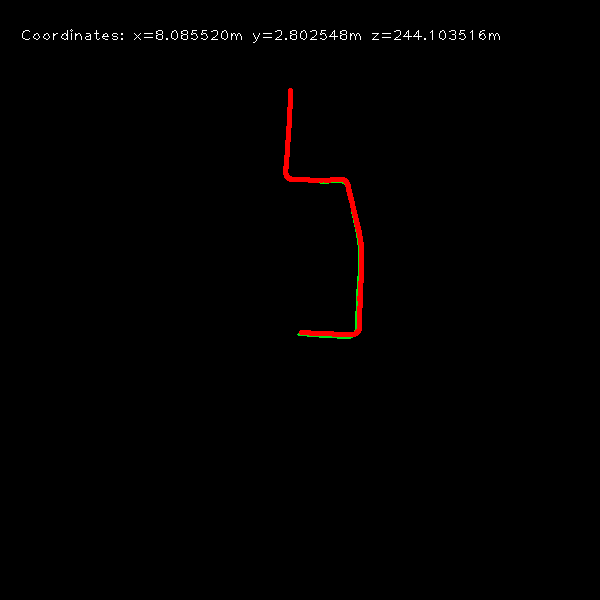

In [48]:
cam = PinholeCamera(1241.0, 376.0, 718.8560, 718.8560, 607.1928, 185.2157)
vo = VisualOdometry(cam, DATASET_DIR + '00.txt')

traj = np.zeros((600, 600, 3), dtype=np.uint8)
fst=0
for img_id in range(fst,500):
    img = cv2.imread(DATASET_DIR + '00/image_2/'+str(img_id).zfill(6)+'.png', 0)

    vo.update(img, img_id)

    cur_t = vo.cur_t

    if(img_id > fst+2):
        x, y, z = cur_t[0], cur_t[1], cur_t[2]
    else:
        x, y, z = 0., 0., 0.
    print(x,y,z)    
    draw_x, draw_y = int(x)+290, int(z)+90
    true_x, true_y = int(vo.trueX)+290, int(vo.trueZ)+90

    cv2.circle(traj, (draw_x,draw_y), 1, (img_id*255/4540,255-img_id*255/4540,0), 1)
    cv2.circle(traj, (true_x,true_y), 1, (0,0,255), 2)
    cv2.rectangle(traj, (10, 20), (600, 60), (0,0,0), -1)
    text = "Coordinates: x=%2fm y=%2fm z=%2fm"%(x,y,z)
    cv2.putText(traj, text, (20,40), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 1, 8)

    cv2.imshow('img', img)
    cv2.imshow('traj', traj)
    cv2.waitKey(1)

cv2.imwrite('map.png', traj)

0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
[-0.06295053] [-0.01453534] [-2.71656252]
[-0.06363134] [-0.00989442] [-3.57598007]
[-0.08211296] [-0.00942683] [-4.43621671]
[-0.11484434] [-0.02637365] [-5.29482398]
[-0.15971829] [-0.01948602] [-6.1541638]
[-0.1775959] [-0.01599744] [-7.01341663]
[-0.19692173] [-0.02168053] [-7.87348725]
[-0.24728223] [-0.00141153] [-8.7323713]
[-0.27932578] [-0.00151282] [-9.59090734]
[-0.30529595] [-0.00359604] [-10.45094515]
[-0.30596465] [0.00343479] [-11.31127322]
[-0.36040663] [0.02715346] [-12.16881206]
[-0.39356327] [0.04125007] [-13.02392436]
[-0.42808933] [0.04114691] [-13.88690101]
[-0.46302086] [0.05498812] [-14.75681426]
[-0.50286562] [0.03287621] [-15.63725051]
[-0.5581224] [0.0185814] [-16.52734469]
[-0.611995] [0.01512116] [-17.42744857]
[-0.64596587] [0.0216461] [-18.33295316]
[-0.70567533] [0.00320789] [-19.24385753]
[-0.75189036] [0.02911662] [-20.15742262]
[-0.83296537] [0.03032149] [-21.0723439]
[-0.84603352] [0.01829568] [-22.0008704]
[-0.890

True

In [49]:
cv2.destroyAllWindows()